<h1><b>DSC170: Raster3. Raster Analysis: Map Algebra, Rules of Map Combination, Suitability</b></h1>

1. Preparing rasters for map combination
1. Rules of map combination
1. Suitability/risk analysis

See slide deck on models (rules) of map combination: https://docs.google.com/presentation/d/18RsaJg3--RakS-FTr1rjxVDilPtbuKAKOuycR_cSJS0/edit?usp=sharing


## Review what we learned to prepare for suitability/risk modeling

So far, we mostly looked at operations over individual raster layers. 

  ---------------------------------------------------------------------------------------------


__1. Creating derivative imagery layers:__

by applying functions packaged with an imagery layer, such as

```
ndvi_colorized = apply(landsat, 'NDVI Colorized')
```

__2. Adding them to map widgets, e.g.:__

```
ndvi_map.add_layer(ndvi_colorized)
```

__3. Improving contrast and coloring, by stretching and applying colormap, e.g.:__

```
land_water = stretch(extract_band(landsat, [4, 5, 3]),
                     stretch_type='PercentClip',
                     min_percent=2, 
                     max_percent=2,
                     dra=True, 
                     gamma=[1, 1, 1])
```
and

```
clrmap=  [[1, 230, 0, 0], [2, 242, 85, 0], [3, 250, 142, 0], [4, 255, 195, 0], [5, 255, 255, 0], [6, 197, 219, 0],  
          [7, 139, 181, 0], [8, 86, 148, 0], [9, 38, 115, 0]]
shaded_relief_lyr = shaded_relief(elevation, colormap=clrmap)
```

(for each mapping, there is a value and  corresponding Red, Green, Blue)
                     
__4. Operations on DEMs: slope, aspect, hillshade, shaded_relief__

__We will now look at how to combine multiple rasters in a suitability analysis__

-----------------------------------------------------------------------------------------------


In [1]:
import warnings
# warnings.filterwarnings("ignore")

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *
from IPython.display import display

# Importing graphviz would be useful as we trace layer operations
import graphviz


In [2]:
gis = GIS(username='izaslavsky_ucsd')


Enter password:  ········


In [3]:
# see if raster analytics is supported
print(arcgis.raster.analytics.is_supported(gis))


True


In [4]:
# available functions in raster.functions
dir(arcgis.raster.functions)

['FLOAT',
 'GIS',
 'INT',
 'ImageryLayer',
 'Item',
 'NDVI',
 'Optional',
 'RFT',
 'Raster',
 'RasterCollection',
 'RasterInfo',
 'Union',
 '_ArcpyRaster',
 '_ArcpyRasterCollection',
 '_FeatureLayer',
 '_LOGGER',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_analysis_job',
 '_analysis_job_results',
 '_analysis_job_status',
 '_arcgis',
 '_clone_layer',
 '_clone_layer_raster',
 '_clone_layer_raster_without_copy',
 '_clone_layer_without_copy',
 '_find_object_ref',
 '_get_raster',
 '_get_raster_ra',
 '_get_raster_ra_rft',
 '_get_raster_url',
 '_input_rft',
 '_json',
 '_pick',
 '_pixel_type_string_to_long',
 '_python_variable_name',
 '_raster_input',
 '_raster_input_rft',
 '_raster_item',
 '_replace_raster_url',
 '_set_multidimensional_rules',
 '_simple_collection',
 'abs',
 'acos',
 'acosh',
 'aggregate',
 'aggregate_cells',
 'annotations',
 'apparent_reflectance',
 'apply',
 'arg_max',
 'arg_median',
 'arg

## Preparing for suitability analysis: get the layers, set extent and geometry, test

### Prep step 1: Loading some earlier imagery layers

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
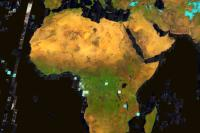

In [5]:
# A few rasters you can use as sources of data. 
# Additionally, you can load your own rasters (eg, from USGS)
# Note that there are different versions of raster servers, with different capabilities

#10.81
usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',gis)
usa_mean_temperature = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Temperature/ImageServer", gis)
usa_landcover_gap = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Landcover_GAP/ImageServer", gis)

usa_federal_lands = ImageryLayer('https://landscape10.arcgis.com/arcgis/rest/services/USA_Federal_Lands/ImageServer',gis)
elev250_esri = ImageryLayer('https://landscape6.arcgis.com/arcgis/rest/services/World_Elevation_GMTED/ImageServer',gis)
usa_wetlands = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Wetlands/ImageServer',gis)
usa_soil_erosion = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erosion_Class/ImageServer',gis)
usa_soil_erodibility = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erodibility_Factor/ImageServer',gis)

#10.71
elev30_usda = ImageryLayer('https://geo.fas.usda.gov/arcgis1/rest/services/G_Elevation/WorldElevation_30m/ImageServer',gis)
elev90_usda = ImageryLayer('https://geo.fas.usda.gov/arcgis1/rest/services/G_Elevation/WorldElevation_90m/ImageServer',gis)

#10.5
global_air_pollution = ImageryLayer('https://sedac.ciesin.columbia.edu/arcgis/rest/services/sedac/sdei_global_annual_avg_pm2_5_2001_2010_image_service/ImageServer',gis)
global_GLDAS_evapotranspiration = ImageryLayer('https://earthobs2.arcgis.com/arcgis/rest/services/GLDAS_Evapotranspiration/ImageServer',gis)

 
# Also, search for layers in AGOl, eg
landsat_item = gis.content.search('Multispectral Landsat', 'Imagery Layer', outside_org=True)[2]
landsat_item

# see functions at https://pro.arcgis.com/en/pro-app/help/data/imagery/calculator-function.htm 

Also, there are multiple imagery services under:
https://landscape7.arcgis.com/arcgis/rest/services
https://landscape10.arcgis.com/arcgis/rest/services
https://landscape2.arcgis.com/arcgis/rest/services (USA ecology, geology, landcover, infrastructure)
(and also https://landscape3.arcgis.com/arcgis/rest/services and 
https://landscape4.arcgis.com/arcgis/rest/services - which appear duplicates)

https://landscape5.arcgis.com/arcgis/rest/services (Africa and S. America)
https://landscape6.arcgis.com/arcgis/rest/services (World environmental)
https://landscape11.arcgis.com/arcgis/rest/services (USA crops, soils, wetlands)
https://landscape12.arcgis.com/arcgis/rest/services (USA imperiled species)

(to get to the actual service URLs, click on any of the service names listed at the above links, and you will see a URL pointing to that service on AGOL under Service Description)


<b>In addition, search the ArcGIS Living Atlas: https://livingatlas.arcgis.com/en/browse/</b>

In [6]:
# here is how you can check for version of the server that manages the raster layer:
usa_elevation.properties.currentVersion

10.81


### Prep step 2: Set extent and geometry for suitability analysis 

Let's define our study area as a collection of zip codes: 92130, 92129, 92121, 92126, 92122

<Item title:"USA ZIP Code Boundaries" type:Feature Layer Collection owner:esri_dm>
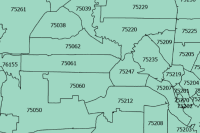

In [7]:
# 2a: Find the zip code layer
zips = gis.content.search('USA zip codes', 'Feature Layer', outside_org=True)
zips[0]


In [8]:
# 2b: Extract the study_area zip codes from the layer, as a feature set
zip_layer = zips[0].layers[0]
study_zips = ["92130", "92129", "92121", "92126", "92122"]
where_clause = "ZIP_CODE IN ({})".format(",".join([f"'{z}'" for z in study_zips]))

zip_query_result = zip_layer.query(
    where=where_clause,
    return_geometry=True,
    out_fields="*"
)

print(f"Features returned: {len(zip_query_result.features)}")

Features returned: 5


In [9]:
# Let's view them as sedf
zip_query_result.sdf

OBJECTID ZIP_CODE    PO_NAME STATE  POPULATION  POP_SQMI   SQMI  \
0     29606    92121  San Diego    CA        5064    397.49  12.74   
1     29607    92122  San Diego    CA       45049   7325.04   6.15   
2     29610    92126  San Diego    CA       73601   7043.16  10.45   
3     29613    92129  San Diego    CA       53077   3943.31  13.46   
4     29614    92130  San Diego    CA       64177   3332.14  19.26   

       Shape__Area  Shape__Length  \
0  46933973.460938   44933.200303   
1  22649224.234375   22469.228357   
2  38524360.730469   30606.238053   
3  49655252.847656   39038.019199   
4  71028612.324219   46736.252109   

                                               SHAPE  
0  {"rings": [[[-13053427.3515042, 3886614.749247...  
1  {"rings": [[[-13050689.5488157, 3874494.091592...  
2  {"rings": [[[-13044251.4417254, 3884333.292476...  
3  {"rings": [[[-13043266.7763015, 3887413.105946...  
4  {"rings": [[[-13052266.2780832, 3891666.481729...

In [10]:
# 2c: Unioning feature geometries

from arcgis.geometry import Geometry

geom_list = []
for feat in zip_query_result.features:
    geom_dict = feat.geometry
    if "spatialReference" not in geom_dict:
        geom_dict["spatialReference"] = zip_query_result.spatial_reference
    geom_list.append(Geometry(geom_dict))

# Start with the first geometry
accumulated_geom = geom_list[0]

# Iteratively union with each subsequent geometry
for g in geom_list[1:]:
    accumulated_geom = accumulated_geom.union(g)

# Now `accumulated_geom` is a single Geometry object
print(type(accumulated_geom))  # arcgis.geometry.Geometry
study_area_geom = accumulated_geom


<class 'arcgis.geometry._types.Polygon'>


In [11]:
# 2d: Retrieve the combined geometry extent and geometry

# Ensure the final geometry has the correct SR

study_area_sr = zip_query_result.spatial_reference

print("Feature layer spatial reference:", study_area_sr)
print("Geometry spatial reference before update:", study_area_geom.spatial_reference)

if not study_area_geom.spatial_reference or (study_area_geom.spatial_reference != study_area_sr):
    # Either missing OR doesn't match the layer's SR
    study_area_geom.spatial_reference = study_area_sr
    print("Geometry spatial reference updated to match layer.")
else:
    print("Geometry spatial reference already matches layer.")
study_area_extent = study_area_geom.extent 



Feature layer spatial reference: {'wkid': 102100, 'latestWkid': 3857}
Geometry spatial reference before update: {'wkid': 4326}
Geometry spatial reference updated to match layer.


In [12]:
# check them out:

print("Combined ZIP codes extent:", study_area_extent) # a tuple (xmin,ymin,xmax,ymax}.
print("Combined ZIP codes geometry:", study_area_geom) # polygon geometry for the union of the five ZIPs.


Combined ZIP codes extent: (-13053427.3515042, 3873859.31025356, -13033563.8355255, 3895114.55454277)
Combined ZIP codes geometry: {'rings': [[(-13040629.5730368, 3892181.55057917), (-13040655.1987836, 3892157.1607305), (-13040697.088308, 3892200.08849048), (-13040744.6439944, 3892252.0531856), (-13040747.2822664, 3892254.94601759), (-13040762.221342, 3892271.58645031), (-13040765.2269683, 3892274.86411408), (-13040838.5753808, 3892354.86858828), (-13040863.7558496, 3892382.32422208), (-13040873.7857357, 3892393.16583128), (-13040892.5987297, 3892413.50880441), (-13040923.6123398, 3892444.56076885), (-13040937.2489774, 3892456.54366432), (-13040947.9356485, 3892465.92562979), (-13040984.4150457, 3892494.19100256), (-13041025.0243959, 3892521.95217684), (-13041046.86528, 3892535.95222036), (-13041068.2497542, 3892547.44421172), (-13041090.3021453, 3892559.73242741), (-13041113.3898077, 3892571.02538863), (-13041142.2438197, 3892583.80462813), (-13041179.2798143, 3892596.88909755), (-130

In [13]:
# There is this weird sequence at the end of study_area_geom:
# 'spatialReference': {'wkid': 4326}, 'spatial_reference': {'wkid': 102100, 'latestWkid': 3857}}

# We only need one spatial reference!! Where  'spatialReference': {'wkid': 4326} comes from - I don't know.

geom_copy = dict(study_area_geom)  # Make a shallow copy so we don't mutate the original

# Remove or unify any "spatialReference" key if it's 4326
if "spatialReference" in geom_copy:
    if geom_copy["spatialReference"].get("wkid") == 4326:
        del geom_copy["spatialReference"]

# Rename "spatial_reference" to "spatialReference" if it exists
if "spatial_reference" in geom_copy:
    geom_copy["spatialReference"] = geom_copy.pop("spatial_reference")

# Ensure the correct spatial reference (102100) is set
geom_copy["spatialReference"] = {"wkid": 102100, "latestWkid": 3857}

# Optionally enforce type to polygon
geom_copy["type"] = "polygon"

print("Cleaned geometry:", geom_copy)



Cleaned geometry: {'rings': [[(-13040629.5730368, 3892181.55057917), (-13040655.1987836, 3892157.1607305), (-13040697.088308, 3892200.08849048), (-13040744.6439944, 3892252.0531856), (-13040747.2822664, 3892254.94601759), (-13040762.221342, 3892271.58645031), (-13040765.2269683, 3892274.86411408), (-13040838.5753808, 3892354.86858828), (-13040863.7558496, 3892382.32422208), (-13040873.7857357, 3892393.16583128), (-13040892.5987297, 3892413.50880441), (-13040923.6123398, 3892444.56076885), (-13040937.2489774, 3892456.54366432), (-13040947.9356485, 3892465.92562979), (-13040984.4150457, 3892494.19100256), (-13041025.0243959, 3892521.95217684), (-13041046.86528, 3892535.95222036), (-13041068.2497542, 3892547.44421172), (-13041090.3021453, 3892559.73242741), (-13041113.3898077, 3892571.02538863), (-13041142.2438197, 3892583.80462813), (-13041179.2798143, 3892596.88909755), (-13041215.3695932, 3892608.8190677), (-13041256.4353534, 3892619.43529163), (-13041296.7107451, 3892627.76903413), (-

### Make sure the geometry and the extent look ok, by drawing them on a map

In [14]:
# convert the study_area_extent tuple (xmin, ymin, xmax, ymax) into a dict:
xmin, ymin, xmax, ymax = study_area_extent

study_area_extent_dict = {
    "xmin": xmin,
    "ymin": ymin,
    "xmax": xmax,
    "ymax": ymax
}
study_area_extent_dict

{'xmin': -13053427.3515042,
 'ymin': 3873859.31025356,
 'xmax': -13033563.8355255,
 'ymax': 3895114.55454277}

In [15]:
# create a polygon feature:

if "spatialReference" not in study_area_extent_dict:
    study_area_extent_dict["spatialReference"] = zip_query_result.spatial_reference

extent_polygon = {
    "rings": [[
        [study_area_extent_dict["xmin"], study_area_extent_dict["ymin"]],
        [study_area_extent_dict["xmin"], study_area_extent_dict["ymax"]],
        [study_area_extent_dict["xmax"], study_area_extent_dict["ymax"]],
        [study_area_extent_dict["xmax"], study_area_extent_dict["ymin"]],
        [study_area_extent_dict["xmin"], study_area_extent_dict["ymin"]]
    ]],
    "spatialReference": study_area_extent_dict["spatialReference"]
}


In [16]:
# show it on a map

my_map = gis.map("San Diego, CA")
my_map.content.draw(geom_copy)
my_map.content.draw(extent_polygon)
my_map



Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

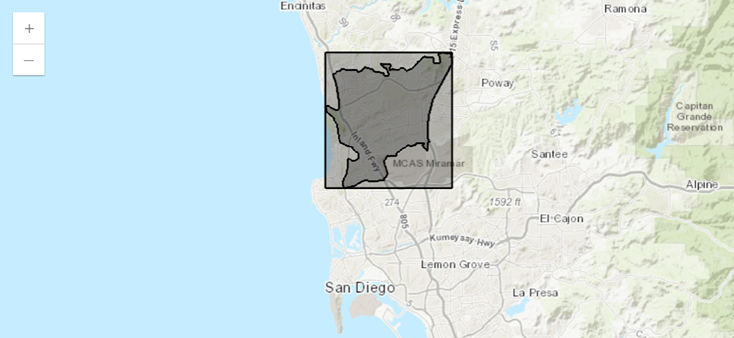

## Suitability Model


Suppose that in our model, we need to combine soil erodibility, elevation, and existing land use/land cover (LULC) to assess area suitability for agricultural development. We want to find cells with low soil erodibility, with lower altitudes (e.g., closer to the ocean, and where most people live), and also on suitable current land uses that may be converted to agricultural use.

  Suitability score == F(soil_erodibility, elevation, LULC)


The relative importance of these factors is, in our model:

- Soil erodibility : 35%
- Elevation: 25%
- LULC: 40%

Note that the first two rasters are continuous (floating point), while the LULC raster represents categories.

To make the problem manageable, we'll convert each raster to a limited number of suitability scores. We'll then use map algebra to calculate the sum of the weighted raster values for each cell. The sum of the weight values must equal 1.0. 



### Our workflow: 
1. clip the three layers to the study area
1. normalize them (using remap) so that they are in compatible units (suitability scores)
1. possibly, binarize the layers (into "suitable == 1", "not suitable == 0")
1. apply colormaps and visualize
1. add them together, applying relative importance weights (or use some other aggregation function)

In [17]:
# to prepare for subsequent modeling, let's set up colormaps

# Create a binary colormap to display the analysis results with 2 colors: red and green.
clrmap2 =  [[1, 230, 0, 0], [0, 38, 115, 0]]

# Create a colormap values from 1 to 9.
clrmap9 =  [[9, 230, 0, 0], [8, 242, 85, 0], [7, 250, 142, 0], [6, 255, 195, 0], [5, 255, 255, 0], [4, 197, 219, 0],  
          [3, 139, 181, 0], [2, 86, 148, 0], [1, 38, 115, 0]]

# Create a colormap to display analysis results with 3 colors
# (eventually, we'd use that to show suitable, moderately suitable, and unsuitable areas)
clrmap3 =  [[1, 230, 0, 0], [2, 255, 255, 0], [3, 38, 115, 0]]


### Working with the Soil Erodibility layer

In [18]:

usa_soil_erodibility.properties

# Look at pixelSize, pixelType, and the range of values

# notice that pixelType": "U8", and the values are from 0 to 64. Pixel resolution is 30
# can you guess in what units?

{
  "currentVersion": 10.81,
  "serviceDescription": "This service is available to all ArcGIS Online users with organizational accounts. For more information on this service, including the terms of use, visit us online at <a href='https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor'> https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor</a>.",
  "name": "USA_Soils_Erodibility_Factor",
  "description": "This service is available to all ArcGIS Online users with organizational accounts. For more information on this service, including the terms of use, visit us online at <a href='https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor'> https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor</a>.",
  "extent": {
    "xmin": -20037507.0672,
    "ymin": -1617169.7091000006,
    "xmax": 20037507.842788246,
    "ymax": 11560120.2909,
    "spatialReference": {
      "wkid": 102100,
      "latestWkid": 3857
    }
  },
  "initialEx

In [19]:
# this is another useful info to explore: codes and definitions for each category
usa_soil_erodibility.attribute_table()

# Now, let's proceed with clipping, remapping, coloring...

{'objectIdFieldName': 'OBJECTID',
 'fields': [{'name': 'OBJECTID',
   'type': 'esriFieldTypeOID',
   'alias': 'OBJECTID',
   'domain': None},
  {'name': 'Value',
   'type': 'esriFieldTypeInteger',
   'alias': 'Value',
   'domain': None},
  {'name': 'Count',
   'type': 'esriFieldTypeDouble',
   'alias': 'Count',
   'domain': None},
  {'name': 'ClassName',
   'type': 'esriFieldTypeString',
   'alias': 'ClassName',
   'domain': None,
   'length': 16},
  {'name': 'Red',
   'type': 'esriFieldTypeSmallInteger',
   'alias': 'Red',
   'domain': None},
  {'name': 'Green',
   'type': 'esriFieldTypeSmallInteger',
   'alias': 'Green',
   'domain': None},
  {'name': 'Blue',
   'type': 'esriFieldTypeSmallInteger',
   'alias': 'Blue',
   'domain': None},
  {'name': 'ErodibilityFactor',
   'type': 'esriFieldTypeString',
   'alias': 'Erodibility Factor',
   'domain': None,
   'length': 8}],
 'features': [{'attributes': {'OBJECTID': 1,
    'Value': 0,
    'Count': 8485680,
    'ClassName': '0 - 0.10',
 

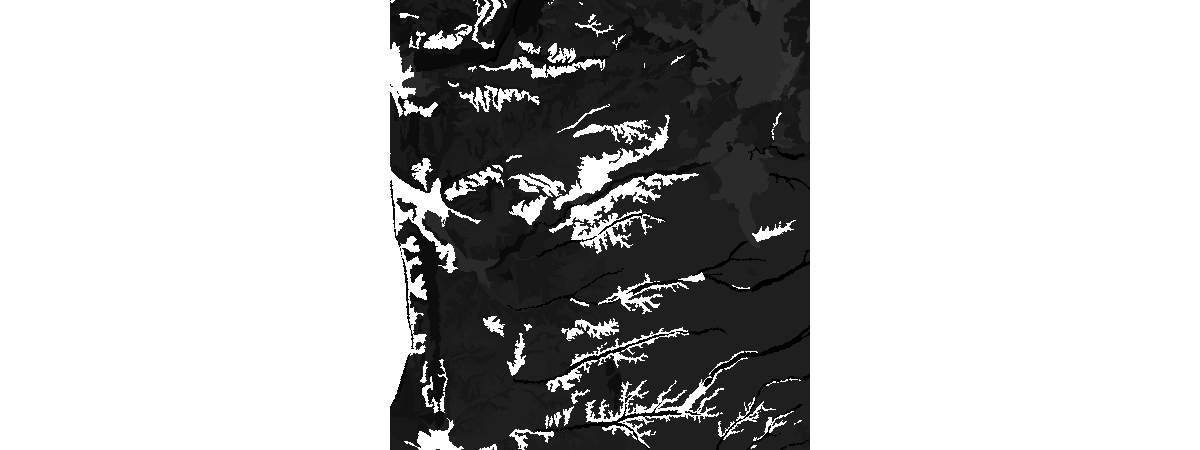

In [20]:
# Clipping to extent (Step 1)

# Set the extent if needed
usa_soil_erodibility.extent = study_area_extent_dict

# Now clip using the polygon geometry
soil_clip = clip(raster=usa_soil_erodibility, geometry=study_area_extent_dict)
soil_clip



In [21]:
# let's explore the result and understand the values...
soil_clip.attribute_table()


{'objectIdFieldName': 'OBJECTID',
 'fields': [{'name': 'OBJECTID',
   'type': 'esriFieldTypeOID',
   'alias': 'OBJECTID',
   'domain': None},
  {'name': 'Value',
   'type': 'esriFieldTypeInteger',
   'alias': 'Value',
   'domain': None},
  {'name': 'Count',
   'type': 'esriFieldTypeDouble',
   'alias': 'Count',
   'domain': None},
  {'name': 'ClassName',
   'type': 'esriFieldTypeString',
   'alias': 'ClassName',
   'domain': None,
   'length': 16},
  {'name': 'Red',
   'type': 'esriFieldTypeSmallInteger',
   'alias': 'Red',
   'domain': None},
  {'name': 'Green',
   'type': 'esriFieldTypeSmallInteger',
   'alias': 'Green',
   'domain': None},
  {'name': 'Blue',
   'type': 'esriFieldTypeSmallInteger',
   'alias': 'Blue',
   'domain': None},
  {'name': 'ErodibilityFactor',
   'type': 'esriFieldTypeString',
   'alias': 'Erodibility Factor',
   'domain': None,
   'length': 8}],
 'features': [{'attributes': {'OBJECTID': 1,
    'Value': 0,
    'Count': 8485680,
    'ClassName': '0 - 0.10',
 

In [22]:
# if there is no atttribute table, try to compute histograms and/or stats
# histograms = soil_clip.compute_histograms(geometry=study_area_extent_dict)

hist_stats = soil_clip.compute_stats_and_histograms(geometry=study_area_extent_dict)

In [23]:
hist_stats

{'statistics': [{'min': 2,
   'max': 55,
   'mean': 28.913840717424833,
   'standardDeviation': 8.725817017426348,
   'median': 30,
   'mode': 33,
   'skipX': 1,
   'skipY': 1,
   'count': 404112}],
 'histograms': [{'size': 56,
   'min': -0.5,
   'max': 55.5,
   'counts': [0,
    0,
    11086,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1133,
    0,
    10187,
    13786,
    0,
    3256,
    0,
    0,
    347,
    14441,
    0,
    4915,
    12752,
    0,
    10142,
    30062,
    5454,
    15269,
    1383,
    27317,
    43233,
    18338,
    42188,
    97034,
    199,
    0,
    0,
    3699,
    0,
    1078,
    0,
    4162,
    0,
    1336,
    0,
    29179,
    0,
    0,
    0,
    0,
    0,
    153,
    1280,
    575,
    0,
    128]}]}

### About soil erodibility

The soil erodibility factor (K-factor) is a quantitative description of the inherent erodibility of a particular soil; it is a measure of the susceptibility of soil particles to detachment and transport by rainfall and runoff. See https://mepas.pnnl.gov/mepas/formulations/source_term/5_0/5_32/5_32.html

Used in Universal Soil Loss Equation (USLE): The Universal Soil Loss Equation (USLE) is a widely used mathematical model that describes soil erosion processes (https://en.wikipedia.org/wiki/Universal_Soil_Loss_Equation; https://milford.nserl.purdue.edu/weppdocs/overview/usle.html)

Computed as A (average annual soil loss) = R * K * L * S * C * P

Where:
- K == soil erodibility factor; 
- R == rainfall erosivity factor; 
- L and S: topographic factors (L == slope length; S == slope); 
- C and P: cropping management factors (C == cropping, P == conservation practice).

Let's recode soil erodibility values into a normalized range (between 1-9): soil_n, applying colormap clrmap9
and also into binary (0 and 1): soil_b, applying colormap clrmap2

We use the Remap function to normalize the input datasets to a common scale of 1 - 9. Locations assigned the value of 1 are considered the least suitable according to our criteria (e.g. the steepest slopes are the least accessible for travel), while locations assigned the value of 9 are considered the most suitable according to our criteria (e.g. areas with the least soil erodability are the best).



In [24]:
# normalized map
soil_n = remap(raster=soil_clip,
                  input_ranges=[0.0,8.0, 8.0,13.0, 13.0,18.0, 18.0,23.0, 23.0,28.0,
                                28.0,33.0, 33.0,38.0, 38.0,43.0, 43.0,64.0],
                  output_values=[9,8,7,6,5,4,3,2,1])

# here, 9 is the best, 1 is the worst:



In [25]:
soil_n.compute_histograms(geometry=study_area_extent_dict)
# notice that the remapped version has the 9 classes we defined

{'histograms': [{'size': 10,
   'min': -0.5,
   'max': 9.5,
   'counts': [0,
    32651,
    5240,
    100932,
    132459,
    60927,
    32455,
    17042,
    11320,
    11086]}]}

In [26]:
# binarized map (optional step 3)
soil_b = remap(raster=soil_clip,
                  input_ranges=[0.0,20.0, 20.0, 65.0],
                  output_values=[1,0],  astype='U8')



#### When you assign new values with remap, keep in mind how you will use the data!

__Why did we asign 0 to areas with a higher level of erodiblity?__

- 

- 

- 

- 

- 

- 

- 

- 

When we have a set of (0,1) maps, where 0 stands for an "excluding factor", we can then multiply them and get a binary map where 0 will show areas excluded by at least one factor

When we combine binary maps and exclude areas if they get any "unsuitable" factor ("one strike and you are out") -  this is called "exclusionary screening". it is one of several map combination techniques. See additional map combination rules in the slide deck at  https://docs.google.com/presentation/d/18RsaJg3--RakS-FTr1rjxVDilPtbuKAKOuycR_cSJS0/edit?usp=sharing

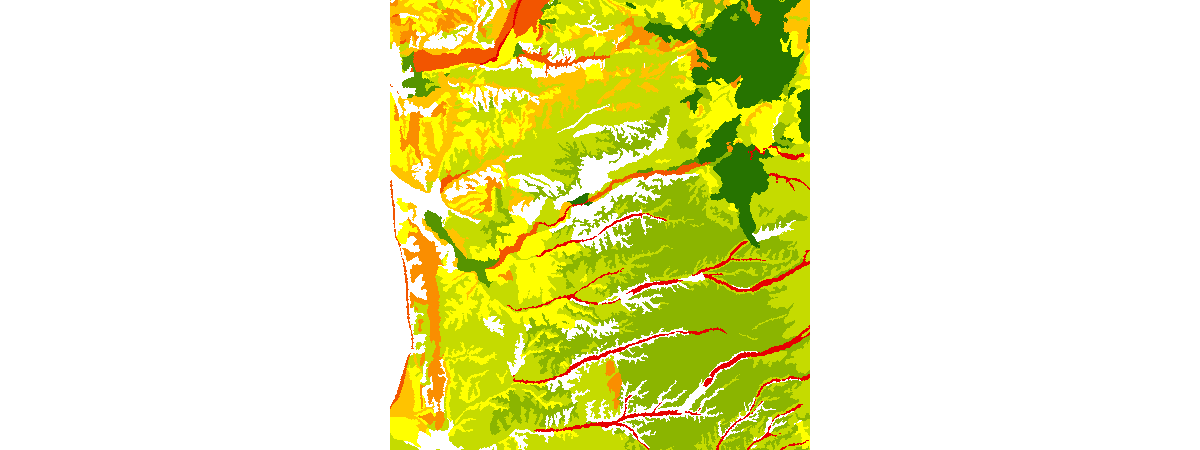

In [27]:
# step 4: apply colormaps to the normalized map:
soil_n_c = colormap(soil_n, colormap=clrmap9)
soil_n_c

In [28]:
# let's map it
map_soil = gis.map("San Diego, CA")
map_soil.extent = study_area_extent_dict
map_soil.legend.enabled=True
map_soil.content.add(soil_n_c)
map_soil


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13053427.3515042, 'ymin': 3873859.31025…

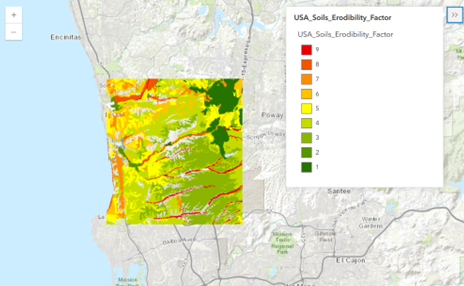

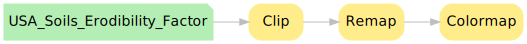

In [29]:
soil_n_c.draw_graph()

In [30]:
# Another way to see the sequence of functions that resulted in a raster:
soil_n_c._fn

{'rasterFunction': 'Colormap',
 'rasterFunctionArguments': {'Raster': {'rasterFunction': 'Remap',
   'rasterFunctionArguments': {'Raster': {'rasterFunction': 'Clip',
     'rasterFunctionArguments': {'ClippingType': 1,
      'Raster': {'url': 'https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erodibility_Factor/ImageServer?token=3NKHt6i2urmWtqOuugvr9XG1zgjF4BaJPnHth_vhCnoTgUJFOfHV-gxJImrbywTsGw09s80NY3DbsKU80EY6R_Mon-J8NWygPP7H137en_NnWeJbxM3gIVxfCKKCVsS1FqJcFGSJXLRMHjw-NHO4LUkG5_Tg3m74Ip-PlddfS6MMbS4HiOne0AStU73lcaiTcVnQdcNC6fHlmuRYEpk_VfutV-1hjOf7hruMRvIej5E.',
       'mosaicRule': {'mosaicMethod': 'esriMosaicNorthwest',
        'sortField': '',
        'mosaicOperation': 'MT_FIRST',
        'ascending': True}},
      'ClippingGeometry': {'xmin': -13053427.3515042,
       'ymin': 3873859.31025356,
       'xmax': -13033563.8355255,
       'ymax': 3895114.55454277,
       'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
      'Extent': {'xmin': -13053427.3515042,
 

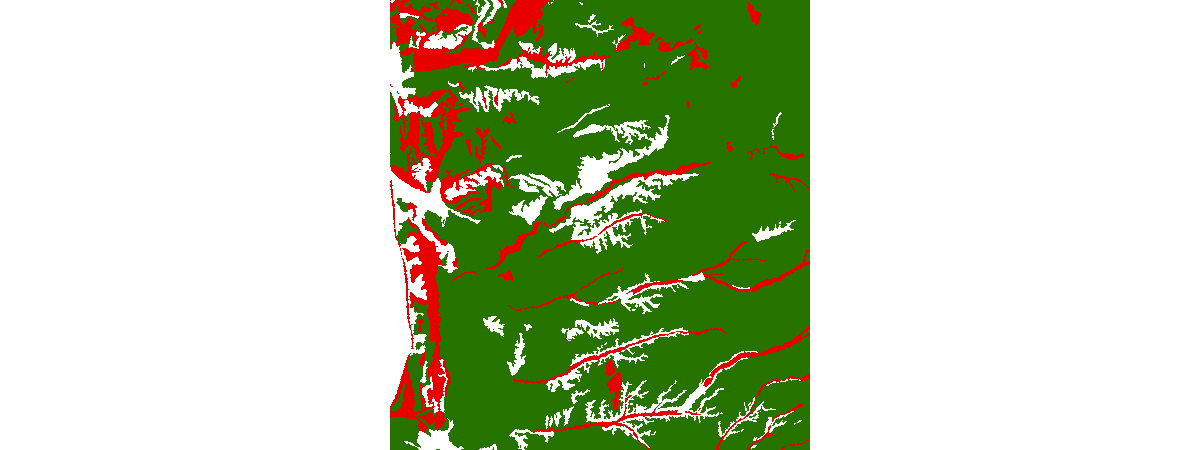

In [31]:
# to the binarized map:
soil_b_c = colormap(soil_b, colormap=clrmap2)
soil_b_c

### Exploring the elevation layer 

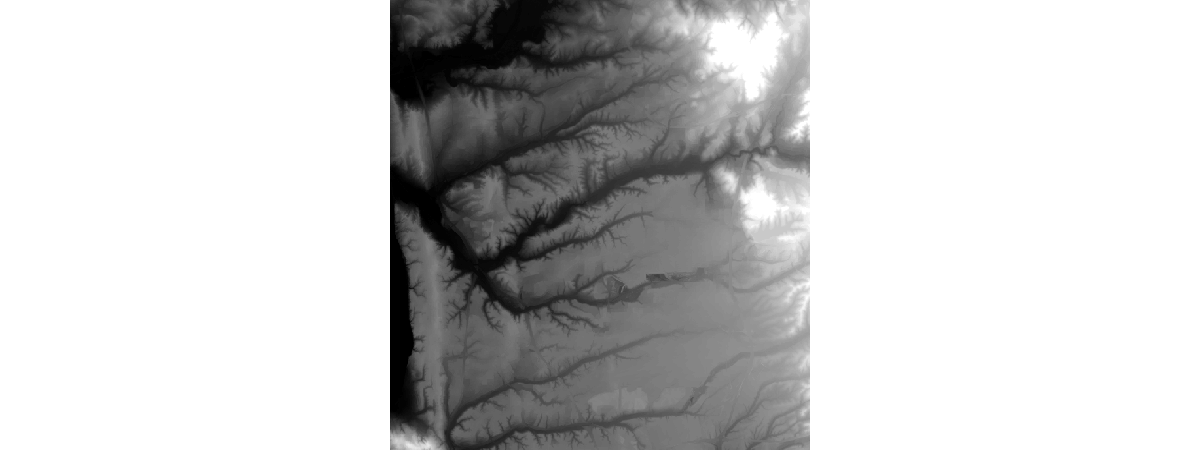

In [32]:
# Elevation map:
usa_elevation.extent = study_area_extent_dict
elev_clip = clip(raster=usa_elevation, geometry=study_area_extent_dict)
# Apply the Stretch function to enhance the display of the clipped layer.
stretch(raster=elev_clip, stretch_type='StdDev', dra='true')

In [33]:
elev_clip.properties

{
  "currentVersion": 10.81,
  "serviceDescription": "<p>For more information on this service, including the terms of use, visit us <a href='http://goto.arcgisonline.com/elevation/WorldElevation/Terrain'>online</a>.</p>",
  "name": "WorldElevation/Terrain",
  "description": "<p>For more information on this service, including the terms of use, visit us <a href='http://goto.arcgisonline.com/elevation/WorldElevation/Terrain'>online</a>.</p>",
  "extent": {
    "xmin": -20037507.84,
    "ymin": -20037508.41,
    "xmax": 20037507.842788246,
    "ymax": 20037508.34,
    "spatialReference": {
      "wkid": 102100,
      "latestWkid": 3857
    }
  },
  "initialExtent": {
    "xmin": -20037507.84,
    "ymin": -20037508.41,
    "xmax": 20037507.842788246,
    "ymax": 20037508.34,
    "spatialReference": {
      "wkid": 102100,
      "latestWkid": 3857
    }
  },
  "fullExtent": {
    "xmin": -20037507.84,
    "ymin": -20037508.41,
    "xmax": 20037507.842788246,
    "ymax": 20037508.34,
    "spa

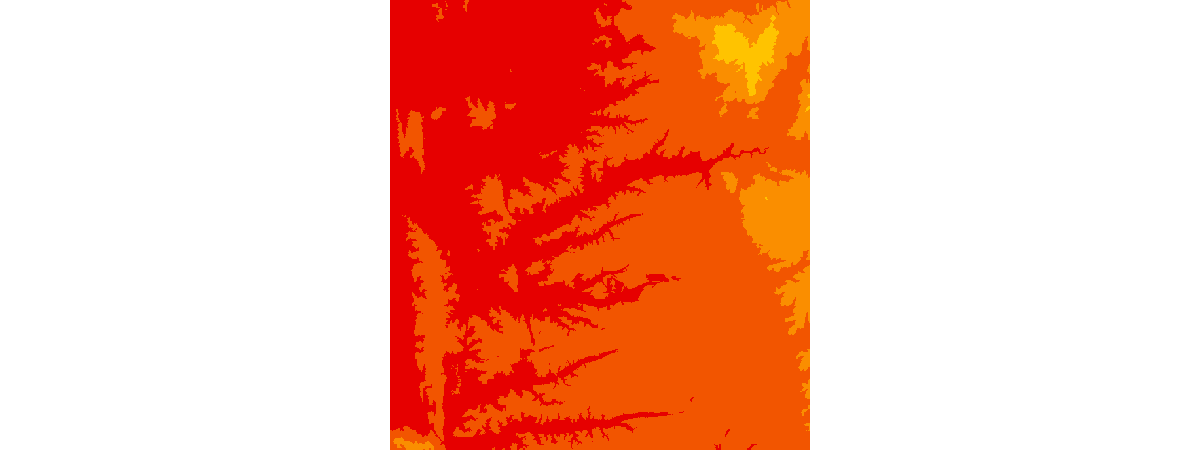

In [34]:
# Reclassify (normalize) the elevation data
elev_n = remap(elev_clip,
                       input_ranges=[0,100, 100,200, 200,300, 300,500, 500,700, 
                                     700,900, 900,1200, 1200,1500, 1500,2800],
                       output_values=[9,8,7,6,5,4,3,2,1])

# here, 9 is the best, 1 is the worst

# Display color-mapped image of the reclassified elevation data
elev_n_c = colormap(elev_n, colormap=clrmap9)
elev_n_c

In [35]:
map_elev = gis.map("San Diego, CA")
map_elev.extent = study_area_extent_dict
map_elev.legend.enabled=True
map_elev.content.add(elev_n_c)
map_elev


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13053427.3515042, 'ymin': 3873859.31025…

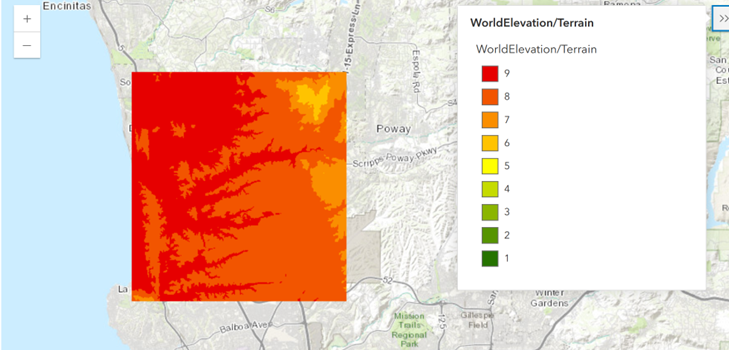

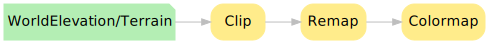

In [36]:
elev_n_c.draw_graph()

### Working with the Landcover layer

In [37]:
# Clipping to extent (Step 1)

usa_landcover_gap.extent = study_area_extent_dict
lulc_clip = clip(raster=usa_landcover_gap, geometry=study_area_extent_dict)

map_lulc = gis.map("San Diego, CA")
map_lulc.extent = study_area_extent_dict
map_lulc.legend.enabled=True
map_lulc.content.add(lulc_clip)
map_lulc


Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13053427.3515042, 'ymin': 3873859.31025…

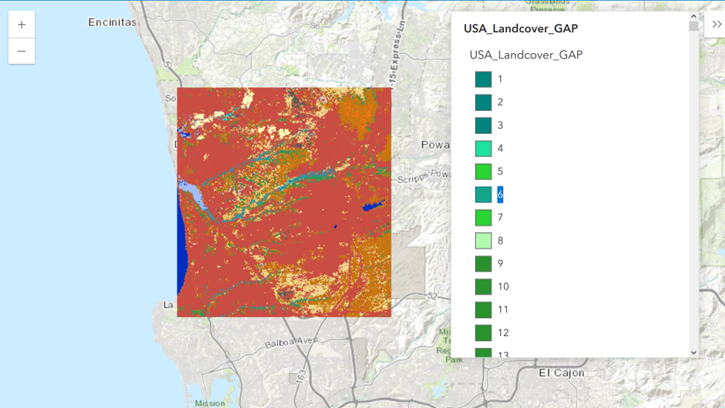

In [38]:
# this is an example of an integer grid - so we can retrieve its attribute table
usa_landcover_gap.attribute_table() 

# See https://www.usgs.gov/core-science-systems/science-analytics-and-synthesis/gap/science/land-cover-data-overview?qt-science_center_objects=4#qt-science_center_objects

# Some additional land cover classifications - see https://my.usgs.gov/confluence/display/nawqadatasynth/Land+Use+Classifications

{'objectIdFieldName': 'OBJECTID',
 'fields': [{'name': 'OID',
   'type': 'esriFieldTypeOID',
   'alias': 'OID',
   'domain': None},
  {'name': 'VALUE',
   'type': 'esriFieldTypeInteger',
   'alias': 'VALUE',
   'domain': None},
  {'name': 'COUNT',
   'type': 'esriFieldTypeInteger',
   'alias': 'COUNT',
   'domain': None},
  {'name': 'RED',
   'type': 'esriFieldTypeDouble',
   'alias': 'RED',
   'domain': None},
  {'name': 'GREEN',
   'type': 'esriFieldTypeDouble',
   'alias': 'GREEN',
   'domain': None},
  {'name': 'BLUE',
   'type': 'esriFieldTypeDouble',
   'alias': 'BLUE',
   'domain': None},
  {'name': 'CL',
   'type': 'esriFieldTypeString',
   'alias': 'CL',
   'domain': None,
   'length': 254},
  {'name': 'NVC_CLASS',
   'type': 'esriFieldTypeString',
   'alias': 'NVC_CLASS',
   'domain': None,
   'length': 254},
  {'name': 'SC',
   'type': 'esriFieldTypeString',
   'alias': 'SC',
   'domain': None,
   'length': 254},
  {'name': 'NVC_SUBCL',
   'type': 'esriFieldTypeString',
   '

__Notice categories in the land cover classification that reflect potential suitability for agricutural use__


 - Class 1 (Forest and Woodland): values from 1 - 289 - not suitable (assigning 1)
 - Class 2 (Shrub and Herb Vegetation): values from 290 - 459  - potentially suitable (assigning 5)
 - Class 3 (Semi-Desert): values from 460-499 - potentially suitable (assigning 3)
 - Class 4 (Polar & High Montane Vegetation): values from 500 - 507 - not suitable (assigning 0)
 - Class 5 (Aquatic Vegetation): values from 508 - 513 - not suitable (assigning 0)
 - Class 6 (Nonvascular & Sparse Vascular Rock Vegetation): values from 514 - 554 - not suitable (assigning 1)
 - Class 7 (Agricultural Vegetation): values from 555 - 557 - not suitable (assigning 0)
 - Class 8 (Introduced & Semi Natural Vegetation): values from 558-563  - most suitable (assigning 9)
 - Class 9 (Recently Disturbed or Modified): values 565-576 - most suitable (assigning 8)
 - Other: (Open Water, Developed & Other Human Use): values from 577 - 584 - not suitable (assigning 0)



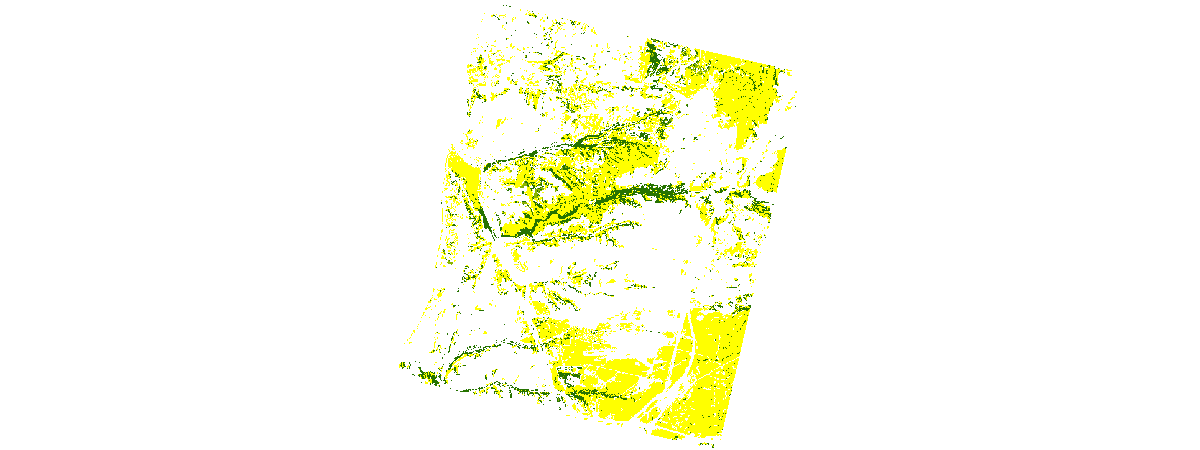

In [39]:

# Let's split landcover into these classes:
lulc_n = remap(raster=lulc_clip,
                  input_ranges=[0.0,289.5, 289.6,459.5, 459.6,499.5, 499.6,507.5, 507.6,513.5,
                               513.6,554.5, 554.6,557.5, 557.6,563.5, 564.5,576.5, 576.6,600.0],
                  output_values=[1,5,3,0,0,1,0,9,8,0])
lulc_n_c = colormap(lulc_n, colormap=clrmap9)
lulc_n.extent = study_area_extent_dict
lulc_n_c.extent = study_area_extent_dict
lulc_n_c

In [40]:
# let's map it
map_lulc = gis.map()
map_lulc.extent = study_area_extent_dict
map_lulc.legend.enabled=True
map_lulc.content.add(lulc_n_c)
map_lulc



Map(extent={'xmin': -13053427.3515042, 'ymin': 3873859.31025356, 'xmax': -13033563.8355255, 'ymax': 3895114.55…

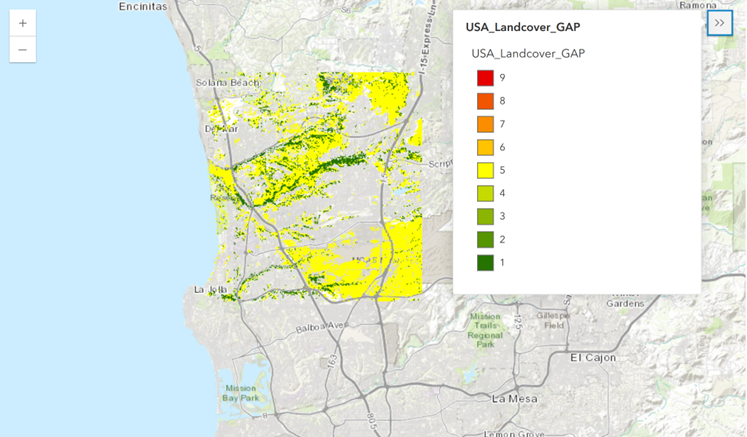

### Finally, combine the layers to compute the suitability model

This will compute a score for each pixel, relfecting a combination of layers.

- Soil erodibility : 35%
- LULC: 40%
- Elevation: 25%

Therefore, 
output = soil*.35 + lulc*.4 + elevation *.25

In [41]:
from arcgis.raster.functions import raster_calculator

from arcgis.raster.functions import extract_band

# raster_calculator works on single-band rasters. Let's make sure the rasters are single-band

soil_one_band = extract_band(soil_n, [0])  # Extract band 0. 
elev_one_band = extract_band(elev_n, [0])
lulc_one_band = extract_band(lulc_n, [0])


# Create a weighted combination of the  rasters:

# result1 = raster_calculator(
#     rasters=[soil_one_band, lulc_one_band, elev_one_band],           # list of rasters
#     input_names=["soil", "lulc", "elev"],       # variable names to use in expression
#     expression="(soil * 0.35) + (lulc * 0.4) + (elev * 0.25)"  # the arithmetic expression
# )

result1 = raster_calculator(
    rasters=[lulc_one_band, soil_one_band, elev_one_band],           # list of rasters
    input_names=["lulc", "soil", "elev"],       # variable names to use in expression
    expression="(soil * 0.35) + (lulc * 0.4) + (elev * 0.25)"  # the arithmetic expression
)

# The difference between the expressions above is which server they execute on!

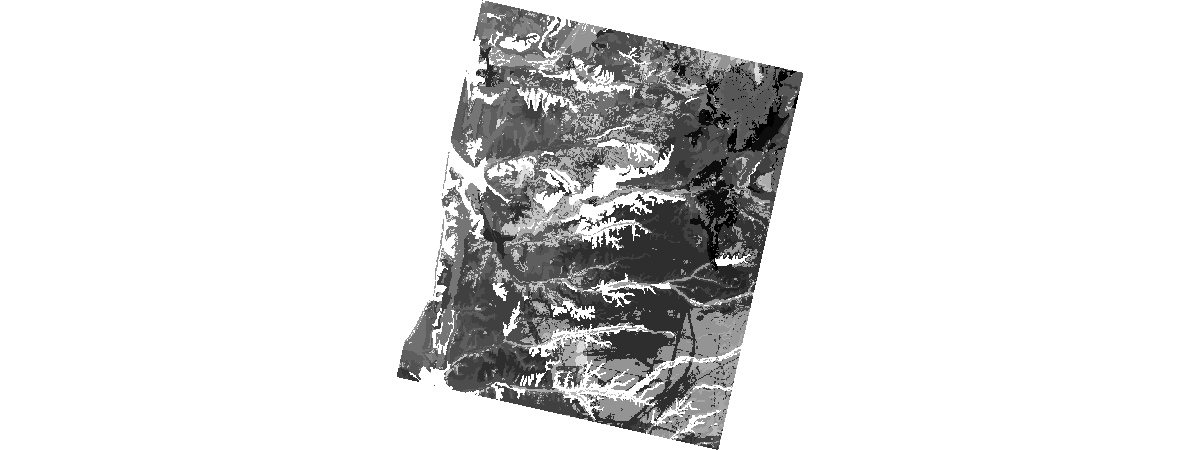

In [42]:
result1

In [43]:
result1.raster_info

{'extent': {'xmin': -2290889.2101138067,
  'ymin': -1726385.2485951362,
  'xmax': 2198700.7898861933,
  'ymax': 1472154.7514048638,
  'spatialReference': {'wkid': 102008, 'latestWkid': 102008}},
 'bandCount': 1,
 'pixelType': 'S16',
 'pixelSizeX': 30,
 'pixelSizeY': 30}

Common Pixel Types:

 - U8: Unsigned 8-bit integer, range 0 to 255.
 - U16: Unsigned 16-bit integer, range 0 to 65,535.
 - S16: Signed 16-bit integer, range -32,768 to +32,767
 - S32: Signed 32-bit integer.
 - F32: 32-bit floating point (commonly used for continuous data such as elevation or analysis outputs).
 - F64: 64-bit floating point (double precision).

In [44]:
result1.compute_stats_and_histograms(geometry=study_area_extent_dict)

{'statistics': [{'min': 1.85,
   'max': 7.4,
   'mean': 4.078618188095976,
   'standardDeviation': 1.0145026085351643,
   'median': 3.830588235294118,
   'mode': 3.047058823529412,
   'skipX': 1,
   'skipY': 1,
   'count': 283823}],
 'histograms': [{'size': 256,
   'min': 1.85,
   'max': 7.4,
   'counts': [23,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    3366,
    0,
    0,
    0,
    0,
    0,
    0,
    92,
    0,
    0,
    0,
    6270,
    0,
    0,
    0,
    0,
    0,
    0,
    621,
    0,
    0,
    0,
    0,
    187,
    0,
    0,
    0,
    0,
    0,
    0,
    507,
    0,
    1816,
    0,
    0,
    0,
    0,
    10,
    0,
    2167,
    0,
    81,
    0,
    0,
    43515,
    0,
    0,
    0,
    5064,
    0,
    0,
    81,
    0,
    0,
    0,
    1160,
    0,
    609,
    0,
    0,
    32754,
    0,
    676,
    0,
    1331,
    0,
    0,
    438,
    0,
    0,
    0,
    26816,
    0,
    0,
    100,
    0,
    10326,
    0,
    2212,
    0,


In [45]:
# let's map it

map_result1 = gis.map("San Diego, CA")
map_result1.extent = study_area_extent_dict
map_result1.legend.enabled = True
map_result1.content.add(result1)
map_result1



Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13053427.3515042, 'ymin': 3873859.31025…

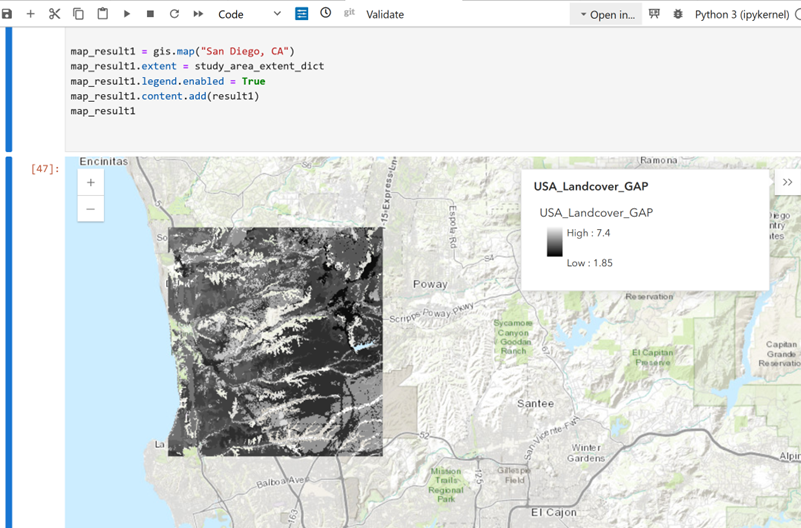

In [46]:
from arcgis.raster.functions import stretch

stretched = stretch(result1, stretch_type="minmax", dra=True)
map_r1_stretched = gis.map("San Diego, CA")
map_r1_stretched.extent = study_area_extent_dict
map_r1_stretched.legend.enabled = True
map_r1_stretched.content.add(stretched)
map_r1_stretched

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13053427.3515042, 'ymin': 3873859.31025…

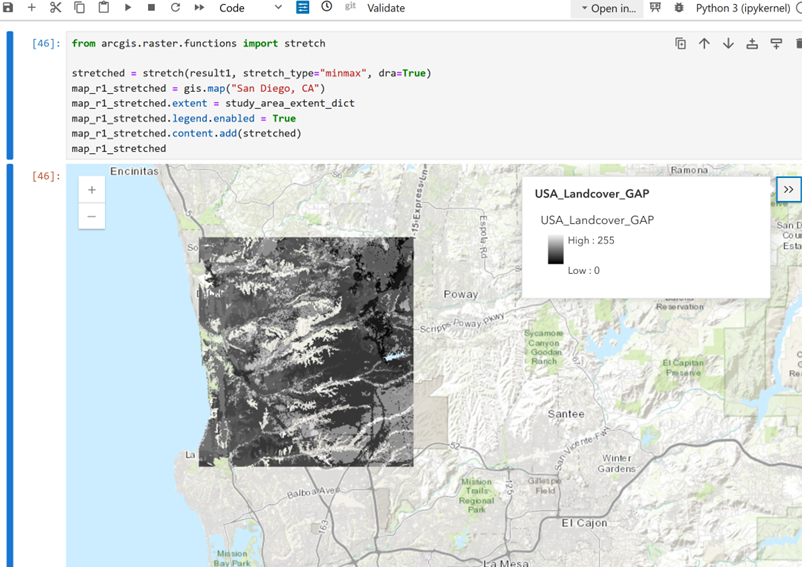

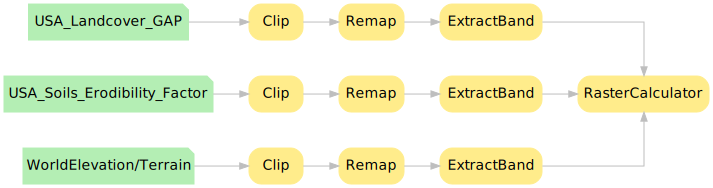

In [47]:
result1.draw_graph()

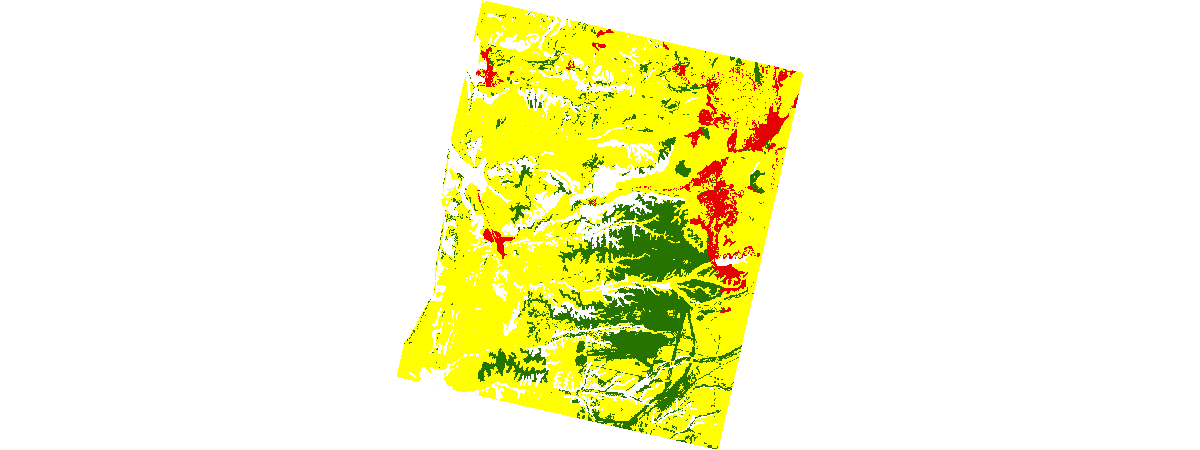

In [48]:
# let's remap the result into most suitable (>6), moderately suitable (3-6), not suitable (3 and lower)

result1_n = remap(raster=result1,
                  input_ranges=[0.0,3.0, 3.1,6, 6.1,10],
                  output_values=[1,2,3],  astype='U8')

# Create a colormap to display the analysis results with 3 colors
clrmap3 =  [[1, 230, 0, 0], [2, 255, 255, 0], [3, 38, 115, 0]]

# 230,0,0  == red   == code 1 == from 0 to 3  == not suitable (https://rgb.to/rgb/230,0,0)
# 38,115,0 == green == code 3 == from 6.1 to 10 == most suitable (https://rgb.to/rgb/38,115,0)

result1_c = colormap(result1_n, colormap=clrmap3)
result1_c

In [49]:
map_r1_final = gis.map("San Diego, CA")
map_r1_final

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [50]:
map_r1_final.extent = study_area_extent_dict      
map_r1_final.legend.enabled =True
map_r1_final.content.add(result1_c, options = {'opacity':0.75})

## A detour: Land Cover Classifications

### LULC in USGS GAP Analysis
See https://www.usgs.gov/core-science-systems/science-analytics-and-synthesis/gap/science/land-cover-data-overview?qt-science_center_objects=4#qt-science_center_objects

### Additional classifications: NLCF, LCCS (FAO)
 - https://www.mrlc.gov/data/legends/national-land-cover-database-2019-nlcd2019-legend

 - https://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1036361/

 - https://en.wikipedia.org/wiki/Land_cover

In [52]:
# this is a global Land Cover Classification System developed by FAO and implemented by ESA. 

lccs = ImageryLayer('https://earthobs3.arcgis.com/arcgis/rest/services/ESA_CCI_Land_Cover_Time_Series/ImageServer', gis)

In [53]:
# let's see it on a map, and explore the range of values
mlccs = gis.map()
mlccs

Map(extent={'type': 'extent', 'xmin': -14999999.999996956, 'ymin': 2699999.9999994184, 'xmax': -6199999.999998…

In [54]:
mlccs.legend.enabled =True
mlccs.content.add(lccs)

The legend shows named categories but not codes. 

You can get corresponding codes from ESA LCCS manual, eg https://www.esa-landcover-cci.org/?q=webfm_send/112 or 
http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-PUG-v2.5.pdf, or http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-Ph2-PUGv2_2.0.pdf 

See that the codes range from 10 to 220.

In [55]:
# We can also get MinValue and MaxValue from lccs.properties (and these are 10 and 220)
lccs.properties

{
  "currentVersion": 10.91,
  "serviceDescription": "This service is available to all ArcGIS Online users with organizational accounts. For more information on this service, including the terms of use, visit us online at <a href='https://goto.arcgisonline.com/earthobs3/ESA_CCI_Land_Cover_Time_Series'>https://goto.arcgisonline.com/earthobs3/ESA_CCI_Land_Cover_Time_Series</a>",
  "name": "ESA_CCI_Land_Cover_Time_Series",
  "description": "This service is available to all ArcGIS Online users with organizational accounts. For more information on this service, including the terms of use, visit us online at <a href='https://goto.arcgisonline.com/earthobs3/ESA_CCI_Land_Cover_Time_Series'>https://goto.arcgisonline.com/earthobs3/ESA_CCI_Land_Cover_Time_Series</a>",
  "extent": {
    "xmin": -180,
    "ymin": -90,
    "xmax": 180,
    "ymax": 90,
    "spatialReference": {
      "wkid": 4326,
      "latestWkid": 4326
    }
  },
  "initialExtent": {
    "xmin": -180,
    "ymin": -90,
    "xmax": 

In [56]:
# check out rasterFunctionInfos above, or

lccs.properties.rasterFunctionInfos



[{
   "name": "Cartographic Renderer",
   "description": "A raster function template.",
   "help": "Displays all ESA land cover classes"
 },
 {
   "name": "Forested Lands",
   "description": "Displays only forested land cover classes (ESA classes 50-90)",
   "help": ""
 },
 {
   "name": "Urban Lands",
   "description": "Displays only the urban land cover class (ESA class 190)",
   "help": ""
 },
 {
   "name": "Converted Lands",
   "description": "Displays only urban lands and lands converted to agriculture (classes 10-40 and 190).",
   "help": ""
 },
 {
   "name": "Simplified Renderer",
   "description": "ESA CCI Reclassified into ten classes, which may be used in conjunction with the Global Predicted Landcover 2050 layer.",
   "help": ""
 },
 {
   "name": "None",
   "description": "A No-Op Function.",
   "help": ""
 },
 {
   "name": "Land Cover",
   "description": "A raster function template.",
   "help": ""
 }]

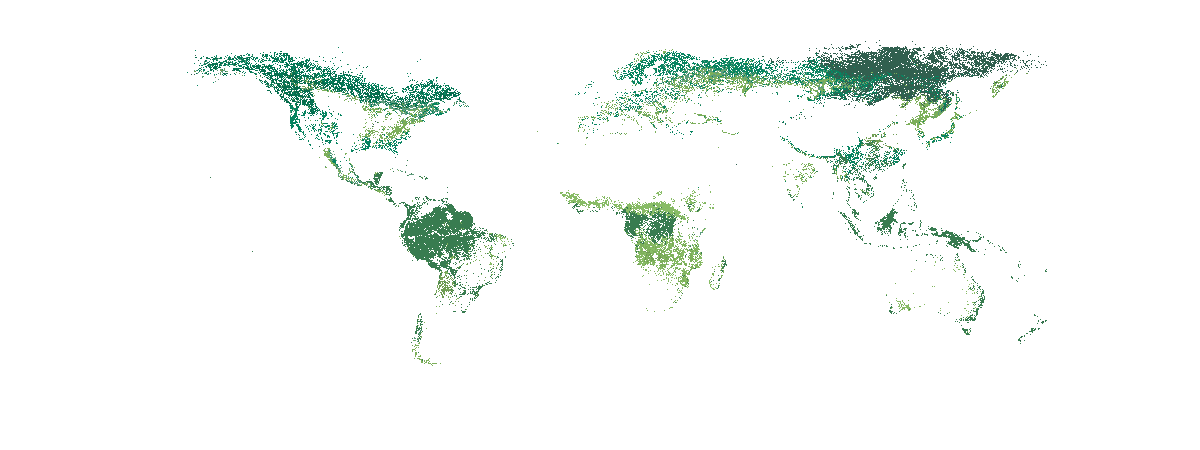

In [57]:
# using these functions, we can generate maps for specific land cover types, eg Forested Lands
# this is a common way to couple specific functions with rasters - as with landsat and DEMs we looked at before

from arcgis.raster.functions import apply
lccs_forest = apply(lccs, 'Forested Lands')
lccs_forest


In [58]:
# Alternatively, you can remap land over types of interest into a binary map.

# For example, you want to have a map of "Bare Land" which is code 200. 
# You can remap the values into a binary map, as below.


lccs_b = remap(raster=lccs,
                  input_ranges=[0,199.5, 199.5,200.5, 200.5,300],
                  output_values=[0,1,0],  astype='U8')
lccs_b_c = colormap(lccs_b, colormap=clrmap2)


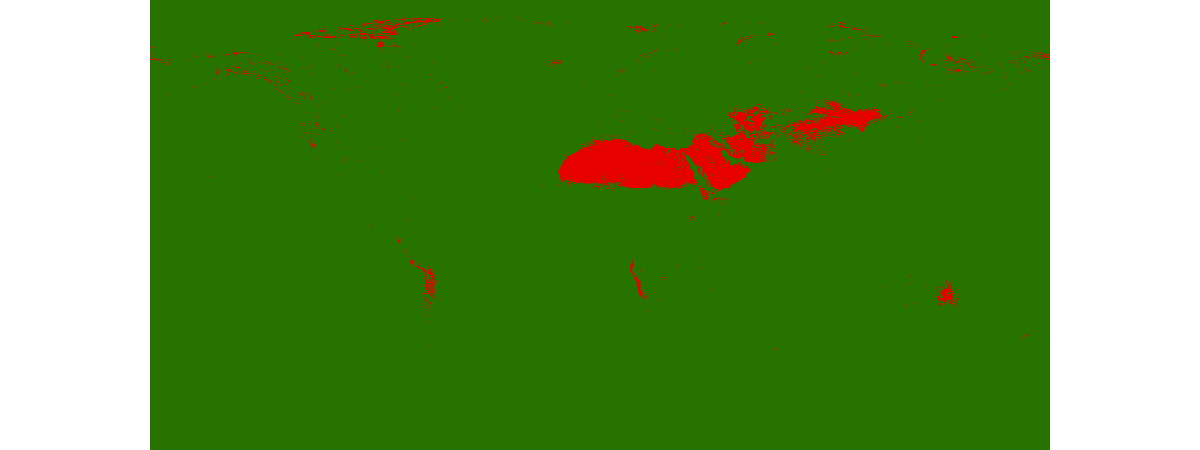

In [59]:
# now, view the layer
lccs_b_c

## Map Algebra

See this slide deck about Map Algebra - https://docs.google.com/presentation/d/1CPkL5uSRCF8OgDpDCRaGoKl2daezW05MRd-5PZ-h6Ok/edit#slide=id.p11 .

There are several ways to add up grid values, but also compute values based on neighborhood, or a zone, or other, more complex, functions.

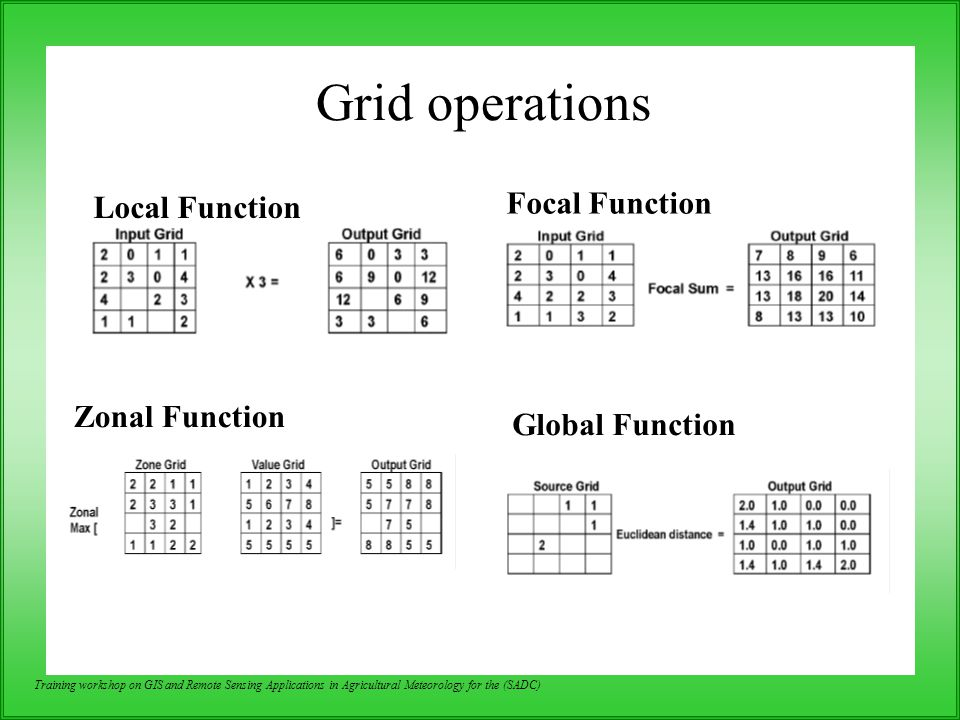

### Local operations

 - __Raster calculator__ (see above): relatively flexible, and allows for additional options (e.g., astype)
 - __Just specify an expression__: result1 = (soil_n * 0.35) + (lulc_n * .4) + (elev_n * 0.25): but less memory efficient
 - __local() function__: arcgis.raster.functions.local(rasters, operation, extent_type='FirstOf', cellsize_type='FirstOf', astype=None, process_as_multiband=None
    - The local function allows you to perform bitwise, conditional, logical, mathematical, and statistical operations on a pixel-by-pixel basis.
 - __arithmetic()__: uses enumerated operations
 - __times()__: handles multiplication

But there are more local functions that take one or more rasters (or ImageryLayers) as input, process them pixel-by-pixel (without regard to neighboring cells), and produce a single output raster or ImageryLayer that you can use in further analysis.

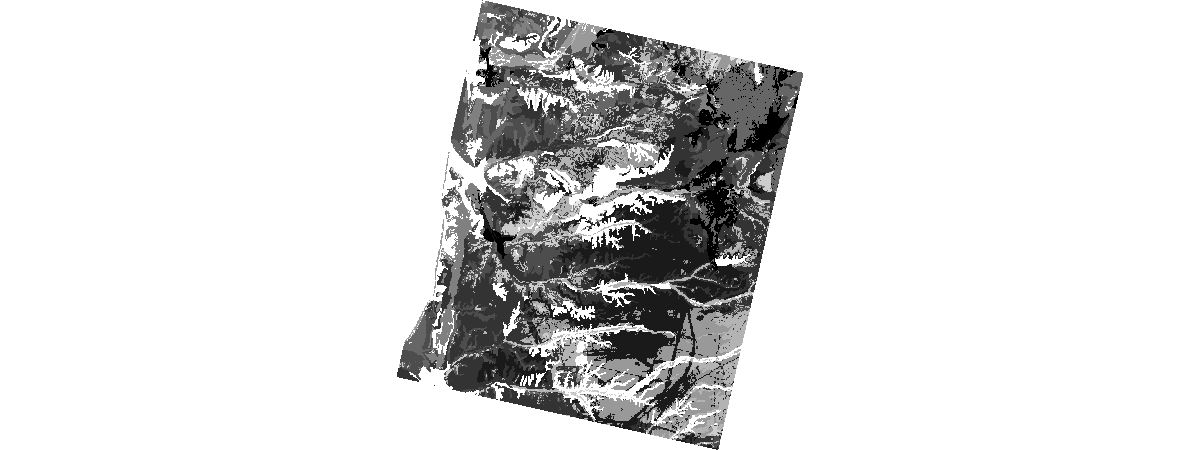

In [60]:
# for example:

res_out2 = arithmetic(lulc_n, soil_n, extent_type='FirstOf', cellsize_type='FirstOf', astype='none', operation_type=1)
res_out2 

# types of operations enumerated at http://resources.arcgis.com/en/help/arcobjects-net/componenthelp/index.html#//004000000149000000
# operation_type = 3 -- means "esriGeoAnalysisFunctionTimes" (multiplication; the same result as before)
# operation_type = 1 -- means "esriGeoAnalysisFunctionPlus" (addition)

### Rules of Map Combination

Our earlier example with raster calculator computing a weighted sum of three rasters demonstrated "weighted overlay", or __"weighting and rating"__ map combination model, a type of Contributory rule (all raster layers contribute to values in the result)

Let's look now at an example of a Dominance rule: __exclusionary screening__ map combination

In [61]:
# The first step in computing exclusionary screening is binarizing input rasters: 

# We computed soil_b earlier, as 
#   soil_b = remap(raster=soil_clip, input_ranges=[0.0,20.0, 20.0,50.0], output_values=[1,0],  astype='U8')
# This resulted in a binary map

# Let's do the same for elevation:
elev_b = remap(raster=elev_n_c,
                  input_ranges=[9,9, 0,8],
                  output_values=[1,0])
# and for LULC: 
lulc_b = remap(raster=lulc_clip,
                  input_ranges=[0.0,289.5, 289.6,459.5, 459.6,499.5, 499.6,507.5, 507.6,513.5,
                               513.6,554.5, 554.6,557.5, 557.6,563.5, 564.5,576.5, 576.6,600.0],
                  output_values=[0,1,0,0,0,0,0,1,1,0])


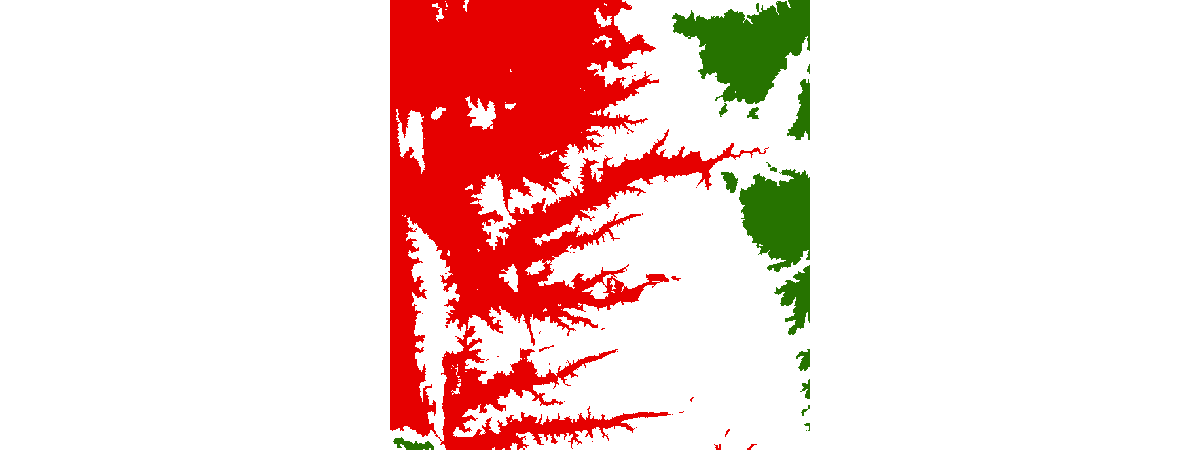

In [62]:
# binary elevation:
elev_b_c = colormap(elev_b, colormap=clrmap2)
elev_b_c


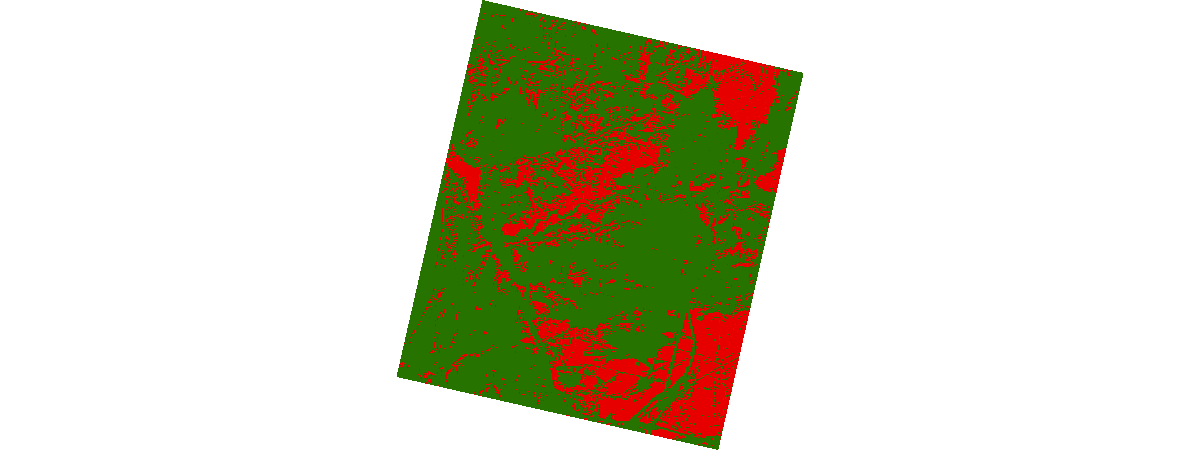

In [63]:
# binary LULC:
lulc_b_c = colormap(lulc_b, colormap=clrmap2)
lulc_b_c


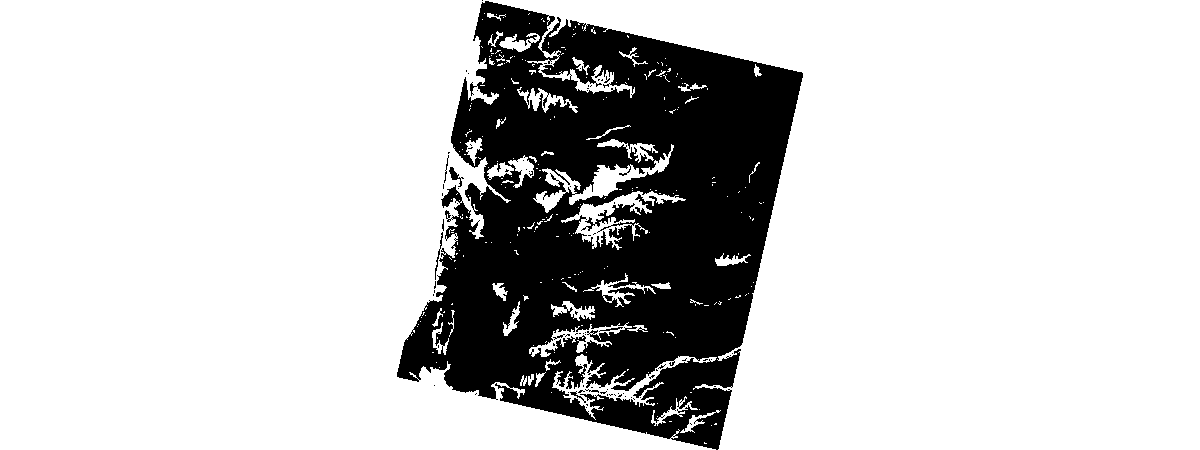

In [64]:
# exclusionary screening:
raster_calculator_output_es = raster_calculator(rasters = [lulc_b, soil_b, elev_b], input_names = ["a","b","c"], expression = "a*b*c", extent_type='FirstOf', cellsize_type='FirstOf')
raster_calculator_output_es

# it is usually better to do this by pairs, and then check results at each step



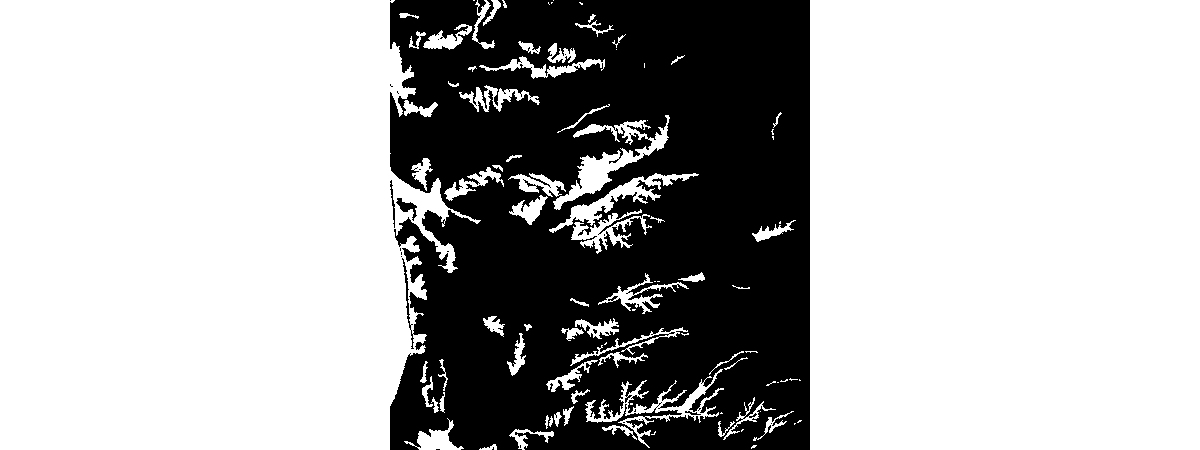

In [65]:
# Yet another way to do exclusionary screening  is "times":

res_out3 = times([soil_b_c, elev_b_c])
res_out3


### Focal operations

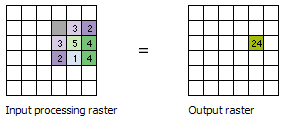

#### focal_statistics

arcgis.raster.functions.focal_statistics(raster, kernel_columns=None, kernel_rows=None, stat_type=None, columns=None, rows=None, fill_no_data_only=None, astype=None)

The focal_statistics function calculates focal statistics for each pixel of an image based on a defined focal neighborhood. 

There are four types of focal statistical functions: 1=Min, 2=Max, 3=Mean, 4=StandardDeviation 
- Min-Calculates the minimum value of the pixels within the neighborhood 
- Max-Calculates the maximum value of the pixels within the neighborhood
- Mean-Calculates the average value of the pixels within the neighborhood. This is the default. 
- StandardDeviation-Calculates the standard deviation value of the pixels within the neighborhood


In [66]:
# We'll compute it for a smaller area, to avoid "image too large" error
# We'll use UCSD zip code: 92093

from arcgis.geocoding import geocode

study_area_gcd = geocode(address='92093', out_sr=usa_elevation.extent['spatialReference'])
study_area_extent_92093 = study_area_gcd[0]['extent']
study_area_extent_92093

{'xmin': -13052680.208477812,
 'ymin': 3876861.7665277114,
 'xmax': -13049340.623754013,
 'ymax': 3880838.1832026294}

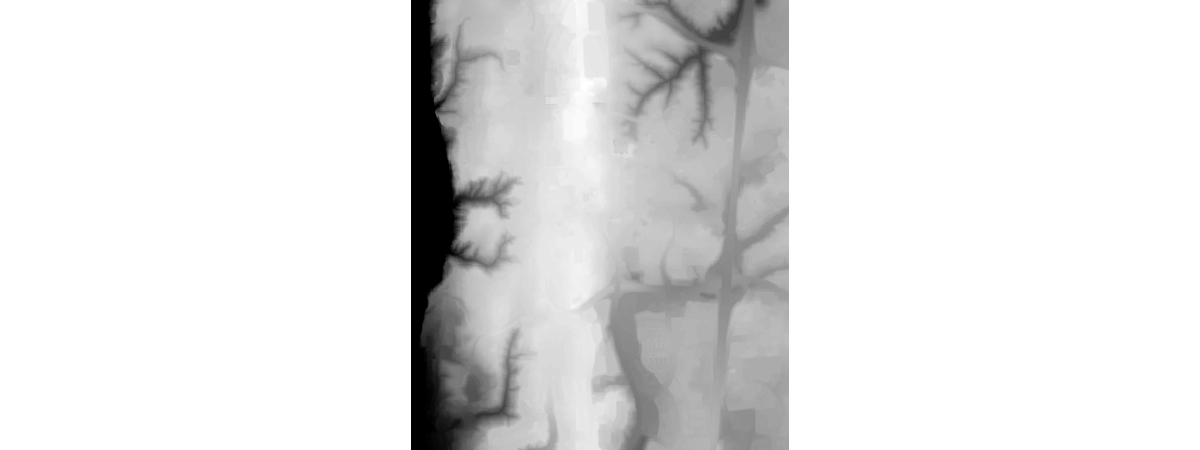

In [67]:
# now use it to set extent for the elevation layer, and then clip it to the extent

usa_elevation.extent = study_area_extent_92093
elev_clip = clip(raster=usa_elevation, geometry=study_area_extent_92093)
stretch(raster=elev_clip, stretch_type='StdDev', dra='true')

In [68]:
# an example of smoothed elevation...
elev_mean50 = focal_statistics(raster = elev_clip, stat_type = 3, columns = 50, rows = 50, fill_no_data_only = True, astype="u4")


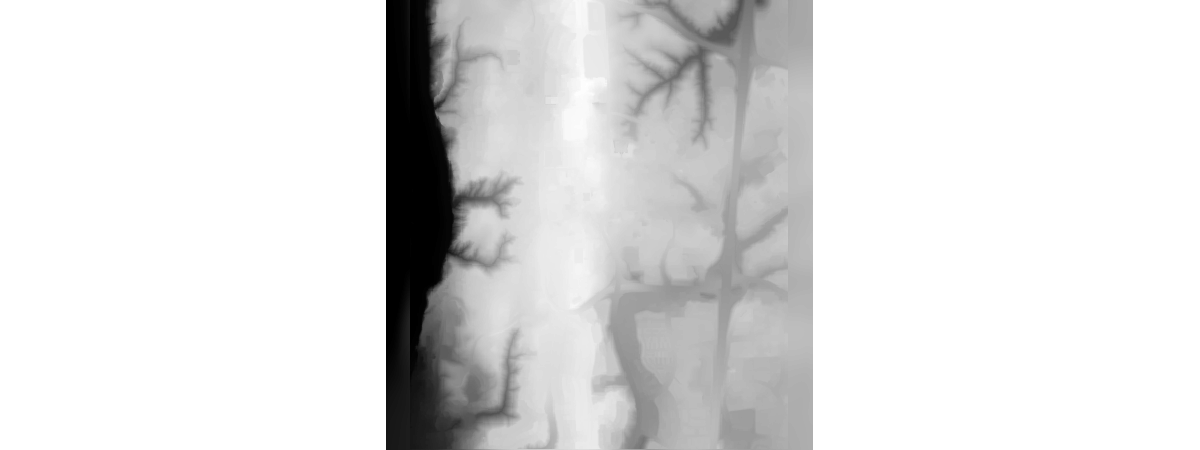

In [69]:
# elev_mean50
stretch(raster=elev_mean50, stretch_type='StdDev', dra='true')

#### focal_stats

arcgis.raster.functions.focal_stats(raster, neighborhood_type=1, width=3, height=3, inner_radius=1, outer_radius=3, radius=3, start_angle=0, end_angle=90, neighborhood_values=None, stat_type=3, percentile_value=90, ignore_no_data=True)

Calculates for each input cell location a statistic of the values within a specified neighborhood around it. 


Neighborhood_type – int, default is 1. The shape of the area around each cell used to calculate the statistic. 1 = Rectangle 2 = Circle 3 = Annulus 4 = Wedge 5 = Irregular 6 = Weight

There are 11 types of statistics available: 1=Majority, 2=Maximum, 3=Mean , 4=Median, 5= Minimum, 6 = Minority, 7=Range, 8=Standard deviation, 9=Sum, 10=Variety, 12=Percentile

Majority = Calculates the majority (value that occurs most often) of the cells in the neighborhood.

Maximum = Calculates the maximum (largest value) of the cells in the neighborhood.

Mean = Calculates the mean (average value) of the cells in the neighborhood.

Median = Calculates the median of the cells in the neighborhood.

Minimum = Calculates the minimum (smallest value) of the cells in the neighborhood.

Minority = Calculates the minority (value that occurs least often) of the cells in the neighborhood.

Range = Calculates the range (difference between largest and smallest value) of the cells in the neighborhood.

Standard deviation = Calculates the standard deviation of the cells in the neighborhood.

Sum = Calculates the sum (total of all values) of the cells in the neighborhood.

Variety = Calculates the variety (the number of unique values) of the cells in the neighborhood.

Percentile = Calculates a specified percentile of the cells in the neighborhood.


#### Differences between focal_stats and focal_statistics
The focal_statistics() function supports Minimum, Maximum, Mean, and Standard Deviation. The focal_stats() function supports Mean, Majority, Maximum, Median, Minimum, Minority, Range, Standard deviation, Sum, and Variety.

The focal_statistics() function supports only Rectangle. The focal_stats() function supports Rectangle, Circle, Annulus, Wedge, Irregular, and Weight neighborhoods.

### Zonal operations

#### zonal_statistics

arcgis.raster.functions.gbl.zonal_statistics(in_zone_data, zone_field, in_value_raster, ignore_nodata=True, statistics_type='MEAN', process_as_multidimensional=None)

Calculates statistics on values of a raster within the zones of another dataset.

A zone is defined as all areas in the input that have the same value. These areas do not have to be contiguous. When the zone and value inputs are both rasters of the same resolution, they will be used directly. If the resolutions are different, an internal resampling is applied to make the resolutions match before the zonal operation is performed.

The following is an example of zonal operation with statistics_type='MIN'

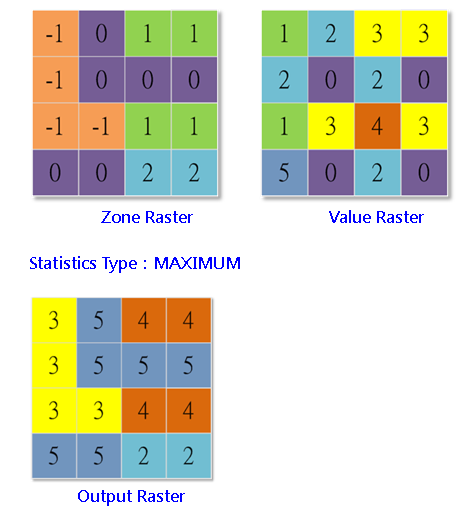

In [109]:
# Examples:

# "What is the average soil erodibility on different types of federal lands in San Diego County? 
# Map the federal lands by the value of average soil erodibility"

usa_federal_lands = ImageryLayer('https://landscape10.arcgis.com/arcgis/rest/services/USA_Federal_Lands/ImageServer',gis)


{'xmin': -13052680.208477812,
 'ymin': 3876861.7665277114,
 'xmax': -13049340.623754013,
 'ymax': 3880838.1832026294}

__Some information about the Federal Lands service:__

 - https://www.arcgis.com/home/item.html?id=986e0b86c8e447549aaecbed728538f0 (imagery service)
 - https://www.arcgis.com/home/item.html?id=5e92f2e0930848faa40480bcb4fdc44e (a companion feature service)

In [73]:
# Get spatial extent of San Diego County
counties = gis.content.search('USA Counties (Generalized)', 'Feature Layer', outside_org=True)
counties


[<Item title:"USA Current Wildfires" type:Feature Layer Collection owner:esri_livefeeds2>,
 <Item title:"StateCountyBoundaries" type:Feature Layer Collection owner:t3gCharlie>,
 <Item title:"Volume, Growth, Removals, and Mortality Statistics for Eastern and Carolina Hemlock and Hemlock Woolly Adelgid Invasion Tracker " type:Feature Layer Collection owner:28200703070040202829_usfs>,
 <Item title:"Metrics_All" type:Table Layer owner:Epidemiology.GIS>,
 <Item title:"USA Counties Generalized Boundaries" type:Feature Layer Collection owner:esri_dm>,
 <Item title:"USA Counties" type:Feature Layer Collection owner:pgamberg@EsriDenver>,
 <Item title:"Annual Soiling Loss Prediction Map_WFL1" type:Feature Layer Collection owner:OBC_GIS>,
 <Item title:"Unemployment comparison- GHC" type:Feature Layer Collection owner:lcps_fhs21_1034806>,
 <Item title:"Polk. Co Area of Operations" type:Feature Layer Collection owner:Ed.Amrhein_TeamRubiconUsa>,
 <Item title:"Iowa County Boundaries" type:Feature Lay

In [74]:
counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[4]

In [86]:
from arcgis.geometry import Geometry, project

counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)
study_area_geom= study_area_query.features[0].geometry


study_area_ex = Geometry(study_area_geom).geoextent  # or just 'extent'

tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

study_area_extent.update({'spatialReference':{'latestwkid':4326, 'wkid':4326}})
study_area_extent

{'xmin': -117.597331316456,
 'ymin': 32.5357813114211,
 'xmax': -116.081552322368,
 'ymax': 33.5103979030633,
 'spatialReference': {'latestwkid': 4326, 'wkid': 4326}}

In [87]:
from arcgis.geocoding import geocode

# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_gcd = geocode(address='San Diego County, CA', out_sr=usa_soil_erodibility.extent['spatialReference'])

# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_gcd[0]['extent']
study_area_extent

{'xmin': -13068598.023681488,
 'ymin': 3816090.6311377175,
 'xmax': -12929003.382226724,
 'ymax': 3982597.532545084}

In [88]:
fed_lands_clip = clip(raster=usa_federal_lands, geometry=study_area_extent)

In [90]:
# this is an example of an integer grid: 7 categories

fed_lands_clip.compute_histograms(geometry = study_area_extent)

{'histograms': [{'size': 7,
   'min': -0.5,
   'max': 6.5,
   'counts': [0, 1719895, 79971, 968, 0, 2468649, 557265]}]}

In [91]:
fed_lands_c = colormap(fed_lands_clip, colormap=clrmap9)


In [93]:
mfed = gis.map("San Diego, CA")
mfed

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [94]:
mfed.legend.enabled =True
mfed.content.add(fed_lands_c)

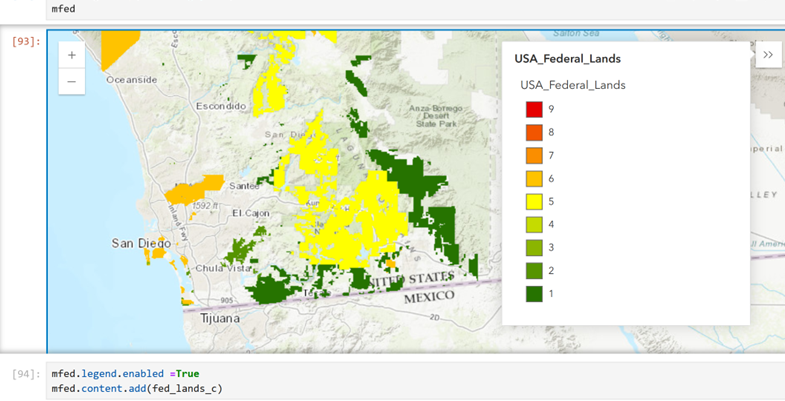

In [95]:
zonal_out = arcgis.raster.functions.gbl.zonal_statistics(fed_lands_c, "Category", soil_clip, ignore_nodata=True, statistics_type='MEAN')

In [96]:
zonal_out # on zonal operations, the content of zonal_out shows the chain of functions

In [97]:
# Also, notice that an additional legend is added to the map
# The values are a function of soil erodibility within each zone

mfed.content.add(zonal_out)

### Global operations

__Distance_Accumulation (formerly known as Cost-Distance)__

arcgis.raster.functions.gbl.distance_accumulation(in_source_data, in_barrier_data=None, in_surface_raster=None, in_cost_raster=None, in_vertical_raster=None, vertical_factor='BINARY 1 -30 30', in_horizontal_raster=None, horizontal_factor='BINARY 1 45', source_initial_accumulation=None, source_maximum_accumulation=None, source_cost_multiplier=None, source_direction='FROM_SOURCE', distance_method='PLANAR', output_back_direction_raster_name=None, output_source_direction_raster_name=None, output_source_location_raster_name=None)

Calculates the least accumulative cost distance for each cell from or to the least-cost source over a cost surface. 

<img src="https://doc.arcgis.com/en/arcgis-online/analyze/GUID-758B6DFA-6820-45B8-8089-5A2B7AB20A0D-web.png">


"Global functions cannot be used for visualization using dynamic image processing. They cannot be applied to layers that are added to a map for on-the-fly image processing or visualized inline within the Jupyter notebook."